# Crytocurrency price forecasting using Neural Networks

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R_squared
from sklearn.metrics import explained_variance_score as EVS

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = 'D:/USMS/UChicago/STUDIES/Autumn 2020/MSCA 31009 2 Machine Learning & Predictive Analytics/Final Project/data/'

In [4]:
# importing the data
BTC_USD = pd.read_csv(data_path+'BTC-USD.csv')
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-11-15,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,24-11-15,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,25-11-15,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,26-11-15,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,27-11-15,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [5]:
# importing the data
XRP_USD = pd.read_csv(data_path+'XRP-USD.csv')
XRP_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,0.004269,0.004351,0.004237,0.004288,0.004288,314451
1,2015-11-24,0.004288,0.004288,0.004201,0.004242,0.004242,197940
2,2015-11-25,0.004242,0.004325,0.004228,0.004318,0.004318,197356
3,2015-11-26,0.004317,0.004435,0.004227,0.004291,0.004291,400520
4,2015-11-27,0.004276,0.004304,0.004229,0.004276,0.004276,199790


In [6]:
# importing the data
ETH_USD = pd.read_csv(data_path+'ETH-USD.csv')
ETH_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-26,0.863273,0.903643,0.804360,0.884183,0.884183,947473
1,2015-11-27,0.882100,0.900051,0.860695,0.867951,0.867951,403813
2,2015-11-28,0.868102,0.929293,0.862122,0.915703,0.915703,462464
3,2015-11-29,0.914144,0.914153,0.860533,0.878614,0.878614,448358
4,2015-11-30,0.879951,0.895054,0.847696,0.873119,0.873119,784439


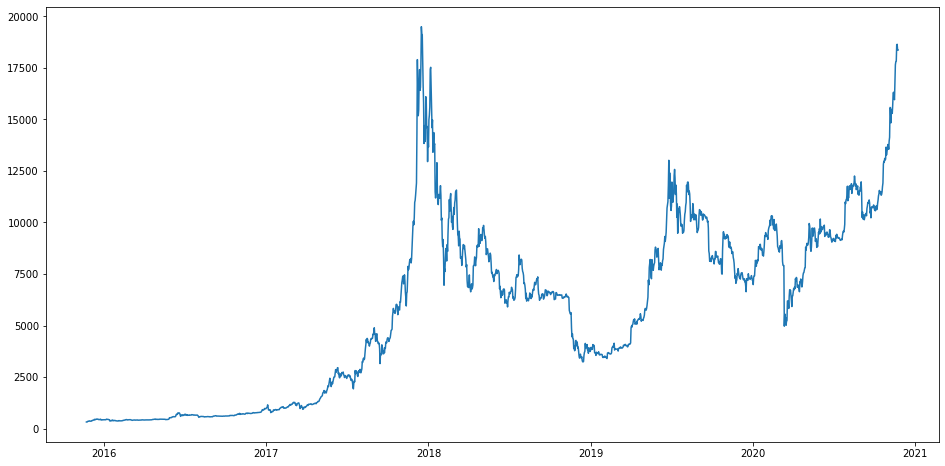

In [7]:
#setting index as date
BTC_USD['Date'] = pd.to_datetime(BTC_USD.Date,format='%d-%m-%y')
BTC_USD.index = BTC_USD['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(BTC_USD['Adj Close'], label='Close Price history')
plt.show()

Linear Regression is not designed to capture the short term dynamics or the autocorrelations which are present in this sequential data. It is more designed to look at the data globally and capture the global trend. We need a model that is able to capture the short term dynamics and short term dependencies within our dataset.

In the world of Neural Networks, we have something called **Recurrent Neural Networks** which is designed to capture these dependencies. Let's apply this and see how it performs in predicting the Bitcoin prices

In [8]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-23,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
2015-11-24,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2015-11-25,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
2015-11-26,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
2015-11-27,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [9]:
BTC_USD.reset_index(drop=True,inplace=True)

In [10]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [11]:
BTC_USD.shape

(1828, 7)

### Making the data ready for feeding to the RNNs

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# fix random seed for reproducibility
np.random.seed(5)

In [14]:
# take adjusted close price column
bitcoin_y = BTC_USD['Adj Close'].values
bitcoin_dataset=bitcoin_y.reshape(-1, 1)

In [15]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_dataset = scaler.fit_transform(bitcoin_dataset)

In [16]:
# split into train and test sets, 25% test data, 75% training data
bitcoin_train_size = int(len(bitcoin_dataset) * 0.75)
bitcoin_test_size = len(bitcoin_dataset) - bitcoin_train_size
bitcoin_train, bitcoin_test = bitcoin_dataset[0:bitcoin_train_size,:], bitcoin_dataset[bitcoin_train_size:len(bitcoin_dataset),:]

In [17]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 240
bitcoin_trainX, bitcoin_trainY = create_dataset(bitcoin_train, look_back)
bitcoin_testX, bitcoin_testY = create_dataset(bitcoin_test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
bitcoin_trainX = np.reshape(bitcoin_trainX, (bitcoin_trainX.shape[0], 1, bitcoin_trainX.shape[1]))
bitcoin_testX = np.reshape(bitcoin_testX, (bitcoin_testX.shape[0], 1, bitcoin_testX.shape[1]))

### Simple RNN

In [19]:
# using 10 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'relu'))
model_RNN.add(Dense(1,activation = 'relu'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 8/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 9/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 10/10
5/5 [=============================

In [20]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [21]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.33
Test RMSE for the bitcoin LSTM: 0.56


We see that using 10 epochs resulted in not so good predictions as the model was not able to learn properly, it is underfitting. The accuracy is very low as well. Let's try with more epochs

In [22]:
# using 100 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'relu'))
model_RNN.add(Dense(1,activation = 'relu'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 10/100
5/5 [===================

5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 77/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 78/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 79/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 80/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 81/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 82/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 83/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 84/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 85/100
5/5 [=======================

In [23]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [24]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.33
Test RMSE for the bitcoin LSTM: 0.56


We now see the model is fitting much better and making **better predictions**.

Checking for vanishing gradient problem in RNN - using **tanh** activation

In [25]:
# using more layers - to show vanishing gradient problem
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'tanh'))
model_RNN.add(Dense(1,activation = 'tanh'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2545 - mean_squared_error: 0.2545
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0474 - mean_squared_error: 0.0474
Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0274 - mean_squared_error: 0.0274
Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 8/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 9/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 10/10
5/5 [=============================

In [26]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [27]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.13
Test RMSE for the bitcoin LSTM: 0.09


We see there is Vanishing Gradient Problem as model is not learning, because weights are not updated

### LSTM - Long Short Term Memory

In [28]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0539 - mean_squared_error: 0.0539
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 10/100
5/5 [===================

5/5 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 77/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 78/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 79/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 80/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 81/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 82/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 83/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 84/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 85/100
5/5 [=======================

In [29]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [30]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.03
Test RMSE for the bitcoin LSTM: 0.05


In [31]:
# invert predictions
bitcoin_trainPredict_reverted = scaler.inverse_transform(bitcoin_trainPredict)
bitcoin_trainY_reverted = scaler.inverse_transform([bitcoin_trainY])
bitcoin_testPredict_reverted = scaler.inverse_transform(bitcoin_testPredict)
bitcoin_testY_reverted = scaler.inverse_transform([bitcoin_testY])

In [32]:
# shift train predictions for plotting
bitcoin_trainPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_trainPredictPlot[:, :] = np.nan
bitcoin_trainPredictPlot[look_back:len(bitcoin_trainPredict_reverted)+look_back, :] = bitcoin_trainPredict_reverted

In [33]:
# shift test predictions for plotting
bitcoin_testPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_testPredictPlot[:, :] = np.nan
bitcoin_testPredictPlot[len(bitcoin_trainPredict_reverted)+(look_back*2)+1:len(bitcoin_dataset)-1, :] = bitcoin_testPredict_reverted

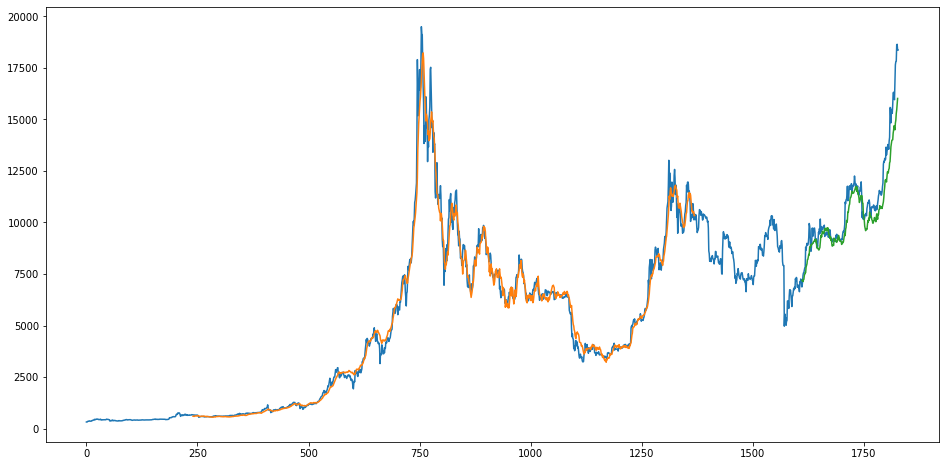

In [34]:
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(bitcoin_dataset))
plt.plot(bitcoin_trainPredictPlot)
plt.plot(bitcoin_testPredictPlot)

Using a different optimizer - **Stochastic Gradient Descent**

In [35]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1104 - mean_squared_error: 0.1104
Epoch 2/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0597 - mean_squared_error: 0.0597
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397 - mean_squared_error: 0.0397
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0359 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0314 - mean_squared_error: 0.0314
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 9/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0268 - mean_squared_error: 0

In [36]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [37]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.15
Test RMSE for the bitcoin LSTM: 0.21


We see **Stochastic Gradient Descent** is not that effective as **ADAM** when it comes to optimizing the cost function

Using a different optimizer - **AdaGrad**

In [38]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='Adagrad',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1245 - mean_squared_error: 0.1245
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1120 - mean_squared_error: 0.1120
Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0983 - mean_squared_error: 0.0983
Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0881 - mean_squared_error: 0.0881
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0812 - mean_squared_error: 0.0812
Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0726 - mean_squared_error: 0.0726
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - mean_squared_error: 0.0680
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0649 - mean_squared_error: 0.0649
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 10/10
5/5 [=============================

In [39]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [40]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.23
Test RMSE for the bitcoin LSTM: 0.33


**AdaGrad** also not performing that well